# Complex PCA Main

1. Group-level CPCA calculation
2. Subject-level CPCA calculation
3. Global-level Age-effect analysis

In [36]:
import numpy as np
from utils import read_dataset
from cpca import complex_svd, reconstruct, cpca, cpca_multiple
from plot import adjust_ax, plot_surface
from stats import circorr, EVR, discriminability_score

from plot import plot_surface

from model import age_prediction, mean_absolute_error
from joblib import Parallel, delayed
from scipy.stats import zscore, pearsonr, spearmanr, rankdata
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd

import statsmodels.api as sm

N_COMP = 10
N_BIN = 32
N_ROI = 200
pattern_names = ['S-A', 'TP-D', 'SM-V']
pattern_colors = ['#F8B77C', '#D54D55', '#381043']

dir_01 = '../results/01-CPCA'
plt.rcParams['axes.titlesize'] = 9    # Default font size for titles
plt.rcParams['axes.labelsize'] = 8     # Default font size for x and y labels
plt.rcParams['xtick.labelsize'] = 7    # Default font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 7    # Default font size for y-axis tick labels
plt.rcParams['font.size'] = 6.5

# Step 1: Group-level CPCA calculation

In [2]:
%%time

for dataset in tqdm(['HCP-A', 'HCP-D']):
    list_pts, demo = read_dataset(dataset)
    list_pts = np.concatenate(list_pts, axis=1).T
    U, S, Vh, patterns = cpca(list_pts, seed=0, svd_results=True)
    np.save(f'{dir_01}/{dataset}_cpca_grp.npy', dict(U=U, S=S, Vh=Vh, patterns=patterns, demo=demo))

100%|██████████| 2/2 [02:10<00:00, 65.46s/it]

CPU times: user 9min 50s, sys: 4min 9s, total: 13min 59s
Wall time: 2min 10s


## Pattern Analysis (HCP-A)

In [2]:
plotter = plot_surface()
patterns = data_A['patterns'].real
list_img = [plotter.plot_dynamics(zscore(patterns[comp, ::5]), cmap='Spectral_r', show=False, vmin=-1.64, vmax=1.64) for comp in range(3)]

## Between Cohort Similarity, Pattern Dominance, Reliability

In [25]:
data_A_grp =  np.load(f'{dir_01}/HCP-A_cpca_grp.npy', allow_pickle=True).item()
data_D_grp =  np.load(f'{dir_01}/HCP-D_cpca_grp.npy', allow_pickle=True).item()

In [7]:
patterns_A_ref = data_A_grp['patterns'].real
patterns_D_ref = data_D_grp['patterns'].real
shift = []
for comp in range(3):
    X = patterns_A_ref[comp]
    n_t = len(X)
    Y = patterns_D_ref[comp]
    print(np.argmax([pearsonr(Y.ravel(), np.roll(X, shift=t, axis=0).ravel())[0] for t in range(n_t)]))

31
8
10


In [4]:
# Similarity Matrix
sim_map = np.zeros((6, 6))
for i, j in product(np.arange(6), repeat=2):
    sim_map[i, j] = circorr(data_A['patterns'].real[i], 
                            data_D['patterns'].real[j])

# Explained Variance Ratio profile
EVR_A = EVR(data_A_grp['S'], n=200)
EVR_D = EVR(data_D_grp['S'], n=200)

In [5]:
ref_Vh = data_A_grp['Vh']

list_Disc = []
for dataset in tqdm(['HCP-A', 'HCP-D']):
    list_pts, demo = read_dataset(dataset)
    n_sub, n_roi, n_tps = list_pts.shape
    mid_tps = n_tps // 2
    patterns1 = cpca_multiple(np.transpose(list_pts[:, :, :mid_tps].real, (0, 2, 1)), ref=ref_Vh)
    patterns2 = cpca_multiple(np.transpose(list_pts[:, :, mid_tps:].real, (0, 2, 1)), ref=ref_Vh)
    
    sub_name = np.asarray(demo.src_subject_id)
    Disc = np.asarray(Parallel(n_jobs=6, verbose=0)(delayed(discriminability_score)(patterns1, patterns2, sub_name, comp) for comp in range(6)))
    list_Disc.append(Disc)

100%|██████████| 2/2 [00:53<00:00, 26.54s/it]


# Step 2: Calculate Subject-Specific Pattern

In [29]:
%%time
ref_Vh = data_A_grp['Vh']

# for dataset in tqdm(['HCP-A', 'HCP-D']):
for dataset in tqdm(['HCP-D']):
    list_pts, demo = read_dataset(dataset)
    U, S, Vh, patterns = zip(*Parallel(n_jobs=8, verbose=0)(delayed(cpca)(pts.T, ref=ref_Vh, svd_results=True) for pts in list_pts))
    np.save(f'{dir_01}/{dataset}_cpca_ind.npy', dict(U=np.asarray(U), S=np.asarray(S), Vh=np.asarray(Vh), patterns=np.asarray(patterns), demo=demo))

100%|██████████| 1/1 [00:09<00:00,  9.97s/it]

CPU times: user 856 ms, sys: 1.64 s, total: 2.5 s
Wall time: 10 s


## Adult Resemblence

In [23]:
data_D_ind = np.load(f'{dir_01}/HCP-D_cpca_ind.npy', allow_pickle=True).item()

In [26]:
patterns_A_ref = data_A_grp['patterns'].real
patterns_D_ind = data_D_ind['patterns'].real

calc_resemblence = lambda x, y: pearsonr(x.ravel(), y.ravel())[0]
n_sub = len(patterns_D_ind)
list_resemblence = np.zeros((6, n_sub))
for comp in range(6):
    list_resemblence[comp] = np.asarray(Parallel(n_jobs=8)(delayed(calc_resemblence)(patterns_D_ind[sub, comp], patterns_A_ref[comp]) for sub in range(n_sub)))

In [27]:
demo = data_D_ind['demo']

pd_fd = np.load('../data/fd_HCP_development.npy', allow_pickle=True)
pd_fd = pd.DataFrame(pd_fd, columns=['sub', 'REST1_AP', 'REST1_PA', 'REST2_AP', 'REST2_PA', 'mean_fd'])
pd_fd['sub'] = pd_fd['sub'].str.replace('_V1_MR', '')
pd_fd.sort_values('sub')
pd_fd = pd_fd[np.isin(pd_fd['sub'], demo['src_subject_id'])].reset_index(drop=True)
demo['MeanFD'] = pd_fd['mean_fd']
mfd = np.nan_to_num(demo['MeanFD'].astype(float))
sex = np.where(demo['sex'] == 'M', 1., 0)
age = np.asarray(demo['age'])

### Sex and MeanFD controlled

In [37]:
print('Figure 1E. Adult Pattern Resemblance')

list_rho = []
for comp in range(3):
    df = pd.DataFrame({
         'X': age,
         'Y': list_resemblence[comp],
        'mfd': mfd,
        'sex': sex
    })
    
    # 1. Rank-transform all variables
    df['X_rank'] = rankdata(df['X'])
    df['Y_rank'] = rankdata(df['Y'])
    df['mfd_rank'] = rankdata(df['mfd'])
    df['sex_rank'] = rankdata(df['sex'])
    
    # 2. Regress X_rank and Y_rank on covariates separately to get residuals
    X_model = sm.OLS(df['X_rank'], sm.add_constant(df[['mfd_rank', 'sex_rank']]))
    X_fit = X_model.fit()
    residuals_X = X_fit.resid  # Residuals of X after accounting for covariates
    
    Y_model = sm.OLS(df['Y_rank'], sm.add_constant(df[['mfd_rank', 'sex_rank']]))
    Y_fit = Y_model.fit()
    residuals_Y = Y_fit.resid  # Residuals of Y after accounting for covariates
    
    # 3. Compute Spearman correlation between the residuals
    rho, p = spearmanr(residuals_X, residuals_Y)
    list_rho.append(rho)
    print(f'Pattern {pattern_names[comp]}: {rho.round(2)} (p={p.round(4)})')    

Figure 1E. Adult Pattern Resemblance
Pattern S-A: 0.42 (p=0.0)
Pattern TP-D: 0.32 (p=0.0)
Pattern SM-V: 0.15 (p=0.0025)


## Age Prediction

In [32]:
patterns = data_D_ind['patterns'].real
age = np.asarray(data_D_ind['demo']['age'])
n_sub = len(patterns)

Y_test, Y_pred = age_prediction(patterns[:, :3].reshape(n_sub, -1), age.reshape(-1, 1), seed=0)
Y_test = np.concatenate(Y_test)[:, 0]
Y_pred = np.concatenate(Y_pred)[:, 0]
pr = pearsonr(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Draw Figure

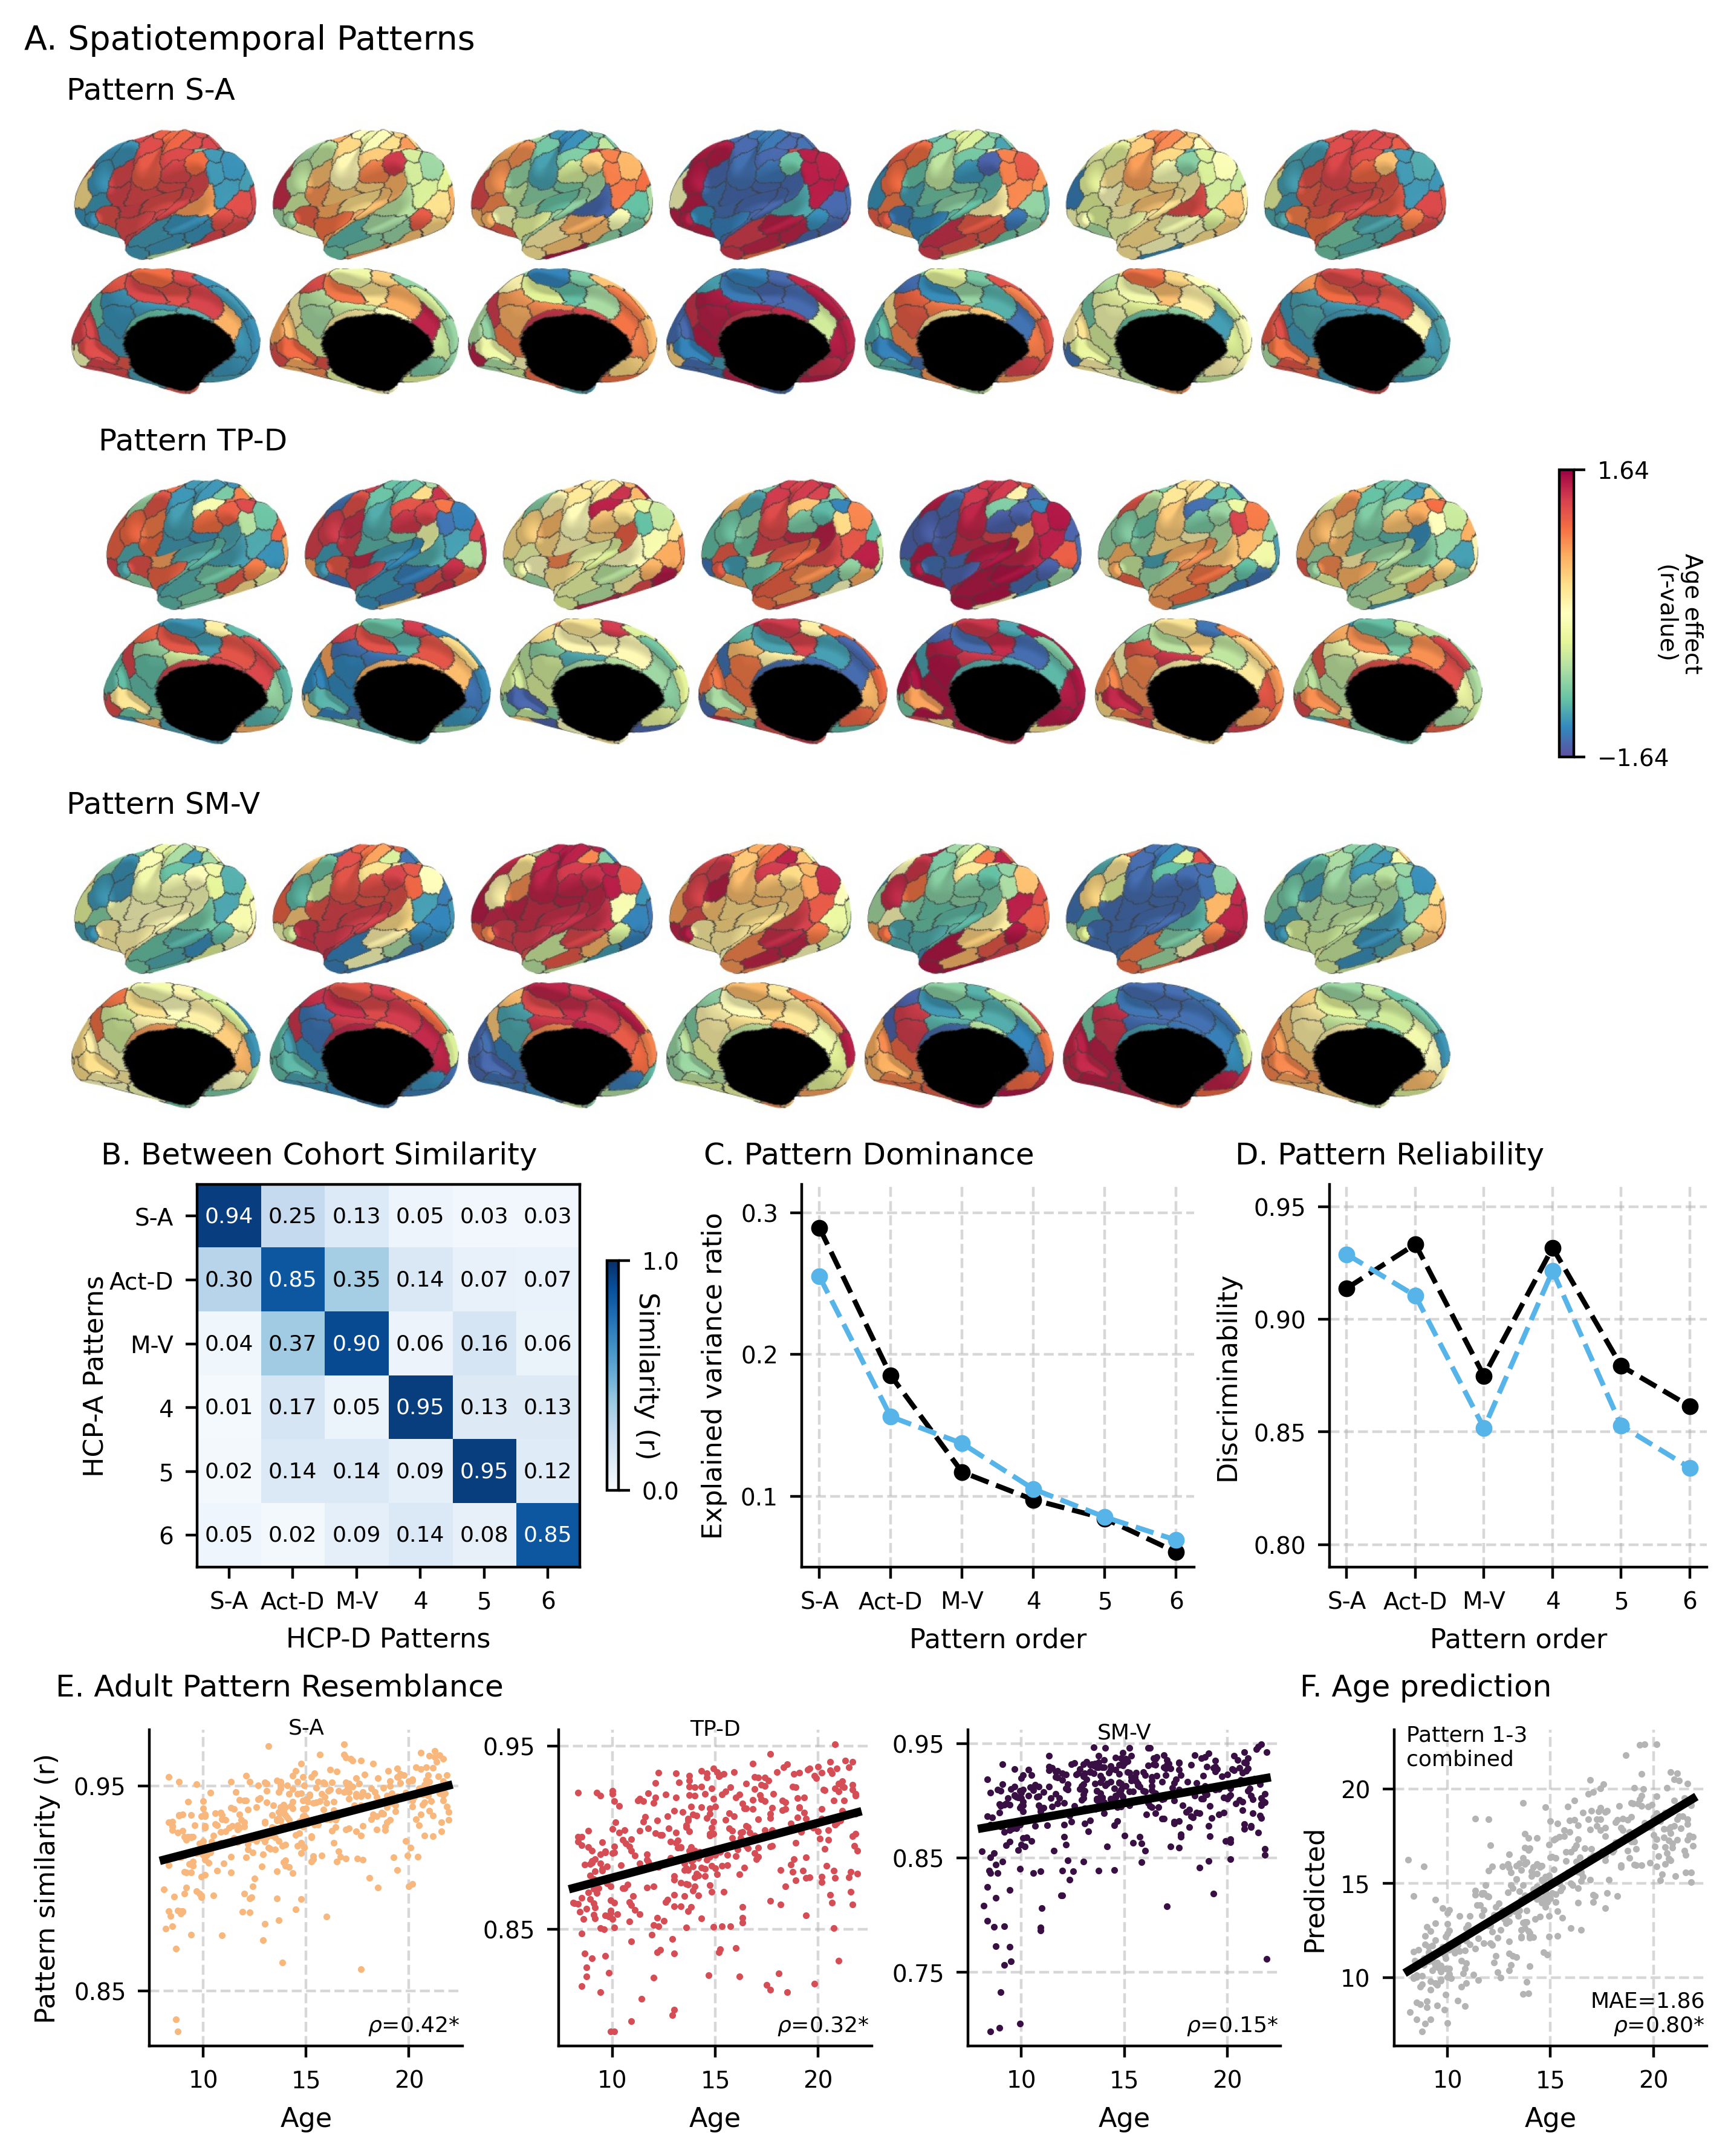

In [38]:
fig = plt.figure(layout='constrained', figsize=(7, 8.8), dpi=400)
subfigs = fig.subfigures(3, 1, wspace=0, hspace=0, height_ratios=[2.1, 1, .9])

figA = subfigs[0] # Figure A
figA.suptitle('A. Spatiotemporal Patterns', ha='left', size=10, x=0)
axs = figA.subplots(3, 1, sharey=False)


for comp in range(3):
    ax = axs[comp]
    ax.axis('off')
    ax.imshow(list_img[comp])
    
    ax.set_title('Pattern ' + pattern_names[comp], loc='left')
    

norm = mpl.colors.Normalize(vmin=-1.64,vmax=1.64)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar = figA.colorbar(sm, shrink=1, ax=axs[1], orientation='vertical')
cbar.ax.set_yticks([-1.64, 1.64])  # vertically oriented colorbar
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.set_ylabel('Age effect\n(r-value)', rotation=270, labelpad=10, size=7)
    
    
fig = subfigs[1]

figB, figC, figD = fig.subfigures(1, 3, wspace=0, hspace=0, width_ratios=[1.3, 1, 1])
        

        
ax = figB.subplots(1)
# Add axis labels

im = ax.imshow(sim_map, cmap='Blues', vmin=0, vmax=1)
cbar = figB.colorbar(im, shrink=0.6, ax=ax, orientation='vertical')
cbar.ax.set_yticks([0, 1], [0.00, 1.00])  # vertically oriented colorbar
cbar.ax.set_ylabel('Similarity (r)', rotation=270, labelpad=-6)



for i in range(sim_map.shape[0]):
    for j in range(sim_map.shape[1]):
        if sim_map[i, j] > 0.5:
            color = 'white'
        else:
            color = 'black'
        ax.text(j, i, f'{sim_map[i, j].round(2):.2f}', ha='center', va='center', color=color)

ax.set_title('B. Between Cohort Similarity', loc='left', pad=6, x=-0.25)
ax.set_xlabel('HCP-D Patterns')
ax.set_ylabel('HCP-A Patterns', labelpad=0)

ax.set_yticks(np.arange(6), ['S-A', 'Act-D', 'M-V', 4, 5, 6])
ax.set_xticks(np.arange(6), ['S-A', 'Act-D', 'M-V', 4, 5, 6])

ax.tick_params(axis='both', which='major') 

ax = figC.subplots(1)
ax.set_title('C. Pattern Dominance', loc='left', pad=6, x=-0.25)
ax.plot(EVR_A[:6], 'o--', color='#000000', ms=4)
ax.plot(EVR_D[:6], 'o--', color='#56B4E9', ms=4)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Pattern order')
ax.set_ylabel('Explained variance ratio')
ax.set_xticks(np.arange(6), ['S-A', 'Act-D', 'M-V', 4, 5, 6])
ax.set_yticks([.1, .2, .3])
ax.set_ylim(.05, .32)



ax =  figD.subplots(1)
ax.set_title('D. Pattern Reliability', loc='left', pad=6, x=-0.25)
ax.plot(list_Disc[0], 'o--', color='#000000', ms=4)
ax.plot(list_Disc[1], 'o--', color='#56B4E9', ms=4)
ax.set_yticks([.8, .85, .9, .95])
ax.set_ylim(.79, .96)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Pattern order')
ax.set_ylabel('Discriminability')
ax.set_xticks(np.arange(6), ['S-A', 'Act-D', 'M-V', 4, 5, 6])



fig = subfigs[2]
axs = fig.subplots(1, 4, sharey=False)


ax = axs[0]
ax.set_title('E. Adult Pattern Resemblance', loc='left', pad=10, x=-0.3, y=1.0)
ax.set_ylabel('Pattern similarity (r)')

list_yticks = [[.85, .95], [.85, .95], [.75, .85, .95]]
for comp in range(3):
    ax = axs[comp]
    X = age
    Y = list_resemblence[comp]
    ax.plot(X, Y, 'o', ms=1, color=pattern_colors[comp])
    
    
    # Plot regression line
    m, b = np.polyfit(X, Y, deg=1)
    xseq = np.linspace(X.min(), X.max(), num=100)
    ax.plot(xseq,  m * xseq + b, color="k", lw=2.5)
    
    
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Age')

    rho = list_rho[comp].round(2)    
    
    ax.set_yticks(list_yticks[comp])
    ax.text(15, Y.max() * 1.005, pattern_names[comp], ha='center')
    ax.text(18, Y.min(), rf'$\rho$={rho:.2f}*')
    ax.grid(True, linestyle='--', alpha=0.5)

    
ax = axs[3]
ax.set_title('F. Age prediction', loc='left', pad=10, x=-0.3, y=1.0)
ax.plot(Y_test, Y_pred, 'o', ms=1, color='#B4B4B4')

# Plot regression line
m, b = np.polyfit(Y_test, Y_pred, deg=1)
xseq = np.linspace(Y_test.min(), Y_test.max(), num=100)
ax.plot(xseq,  m * xseq + b, color="k", lw=2.5)

ax.text(8, Y_pred.max() * .95, 'Pattern 1-3\ncombined', ha='left')
ax.text(22.5, Y_pred.min(), f'MAE={mae.round(2):.2f}\n' + rf'$\rho$={pr[0].round(4):.2f}*', ha='right')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Age')
ax.set_ylabel('Predicted')
ax.set_yticks([10, 15, 20])
ax.grid(True, linestyle='--', alpha=0.5)

# Functional Gradient

In [40]:
from brainspace.gradient.gradient import GradientMaps

def calc_conn(dataset):
    list_pts, _ = read_dataset(dataset)
    list_conn = np.nan_to_num([np.corrcoef(pts) for pts in list_pts])
    list_conn[:, np.eye(200) == 1] = 0
    return list_conn

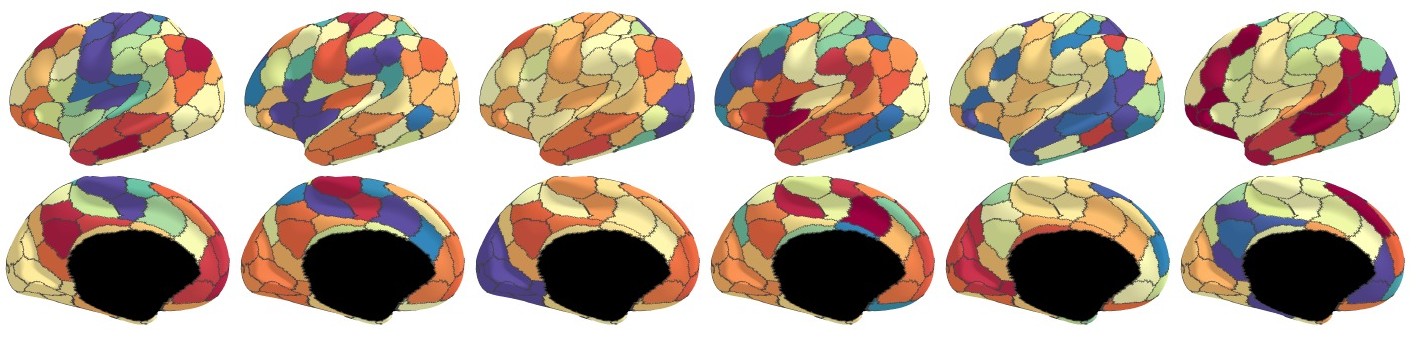

CPU times: user 7.6 s, sys: 8.06 s, total: 15.7 s
Wall time: 24.9 s


In [15]:
%%time

kernel = 'pearson'
dataset = 'HCP-A'
list_conn = calc_conn(dataset)

gm = GradientMaps(n_components=N_COMP, kernel=kernel, approach='pca', alignment=None, random_state=0)
gm.fit(np.mean(list_conn, axis=0))#, sparsity=0.9)
reference = gm.gradients_
perm = np.arange(10) # Reorder to match first 3 components with Dynamic patterns
perm[:3] = [0, 2, 1]
reference = reference[:, perm]

# reference = zscore(reference, axis=0)
np.save(f'{dir_01}/{dataset}_gradient_grp.npy', reference)

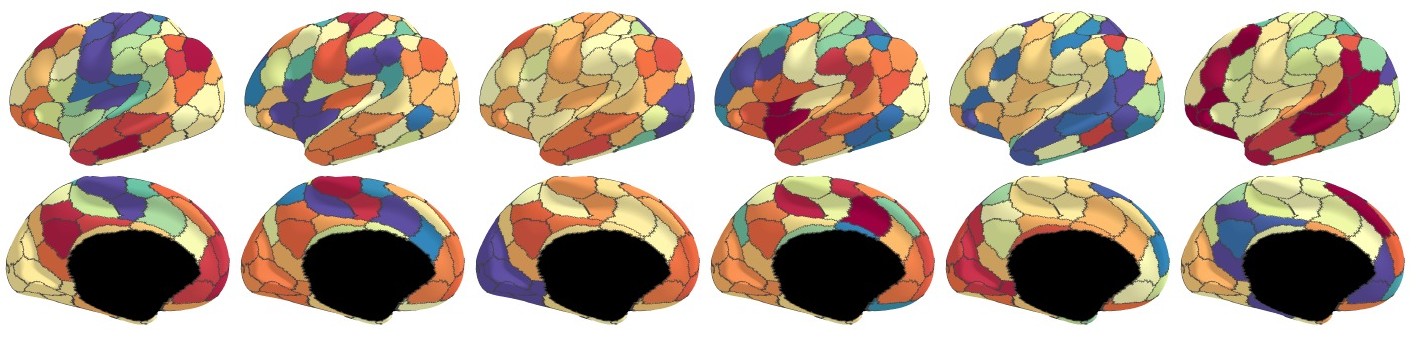

In [16]:
dataset = 'HCP-A'
reference = np.load(f'{dir_01}/{dataset}_gradient_grp.npy')
plotter = plot_surface()
plotter.plot_dynamics(zscore(reference, axis=0)[:, :6].T, vmin=-1.64, vmax=1.64, cmap='Spectral')

In [16]:
reference = np.load(f'{dir_01}/{dataset}_gradient_grp.npy')
dataset = 'HCP-D'
list_conn = calc_conn(dataset)

gm = GradientMaps(n_components=N_COMP, kernel=kernel, approach='pca', random_state=0, alignment='procrustes')
gm.fit(list(list_conn), reference=reference, n_iter=1)#, sparsity=0.8)
np.save(f'{dir_01}/{dataset}_gradient_ind.npy', gm.aligned_)